# Recommendation system

The code is based on paper: [Slope One Predictors for Online Rating-Based Collaborative Filtering](https://web.archive.org/web/20100208224546/http://www.daniel-lemire.com/fr/abstracts/SDM2005.html)

----

2 класса коллаборативной фильтрации:

- фильтрация по схожести пользователей, базирующаяся на измерении подобия пользователей
- фильтрация по схожести предметов, сравнивающая оценки, данные различными пользователями

In [10]:
import pandas as pd
import numpy as np

df = pd.read_csv('u.data', sep='\t', names = ['user id', 'item id', 'rating', 'timestamp'])
df.drop('timestamp', axis = 1, inplace = True)

In [35]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = df['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution of {} book-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [52]:
# Number of ratings per book
data = df.groupby('item id')['rating'].count().clip(upper = 100) # number of ratings per book if >100 then = 100

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 100,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution of Number of Ratings Per Film ',
                   xaxis = dict(title = 'Number of Ratings Per Film'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

# The distribution is not normal. Most of films got just 1 rating

# Films which got most number of ratings

In [43]:
df.groupby('item id')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,item id,rating
49,50,583
257,258,509
99,100,508
180,181,507
293,294,485
285,286,481
287,288,478
0,1,452
299,300,431
120,121,429


In [57]:
# make user-item-evaluate matrix

user_num = 943
iter_num = 1682

def get_eval_matrix(df):
    ret = np.zeros((user_num, iter_num))
    for i, data in df.iterrows():
        ret[data[0] - 1][data[1] - 1] = data[2]
    return ret

base_mat = get_eval_matrix(df)

In [58]:
base_mat

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

# shape

In [4]:
base_mat.shape

(943, 1682)

# Sparsity

In [14]:
print('Sparsity of matrix is:', round(np.count_nonzero(base_mat)/(base_mat.shape[0] * base_mat.shape[1]),3))

Sparsity of matrix is: 0.063


# Rank of matrix

In [15]:
from numpy.linalg import matrix_rank
matrix_rank(base_mat)

943

In [61]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd
import matplotlib.pyplot as plt

u, sigma, v = svd(base_mat)

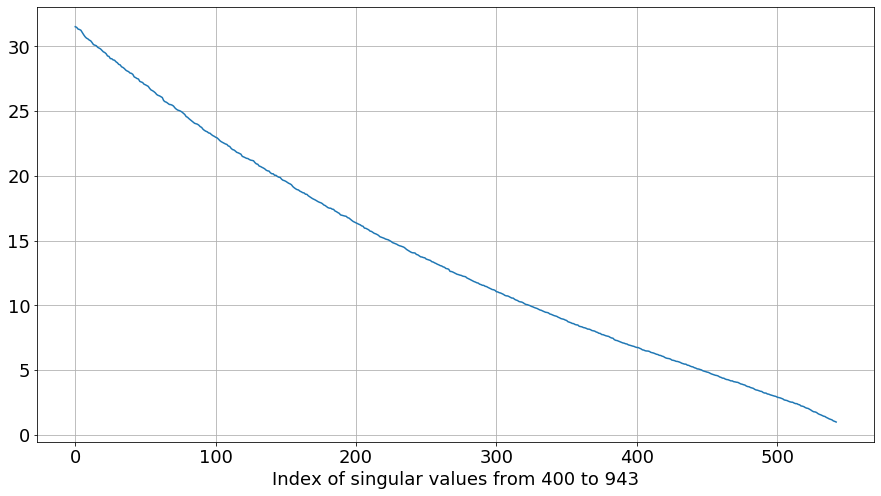

In [80]:
plt.figure(figsize = [15,8])
plt.plot(sigma[400::]/sigma[-1])
plt.xlabel("Index of singular values from 400 to 943", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(True)

# Almost all singular are significant

# But first singular value is high enough 

In [85]:
sigma[1]

244.8363456655035

In [86]:
sigma[-1]

0.6433575642372296

# From Eckart Young theorem we know that error of low-rank aproximation is $\sigma_{r+1}$. Hence lets choose $r = 700$

In [91]:
u, s, v = np.linalg.svd(base_mat, full_matrices = True)
print('701th singular value is: ', round(s[700],4))
r = 700
u1 = u[:, :r]
s1 = s[:r]
v1 = v[:r, :]
Low_rank_aprox = u1.dot(np.diag(s1).dot(v1))

print('Error for aproximation is: ',round(np.linalg.norm(base_mat - Low_rank_aprox, 2),3))

701th singular value is:  7.115
Error for aproximation is:  7.115


# New matrix is Low_rank_aprox

In [75]:

start = time.time()
r = 700
u, s, v = np.linalg.svd(base_mat, full_matrices = True)
u1 = u[:, :r]
s1 = s[:r]
v1 = v[:r, :]
Low_rank_aprox = u1.dot(np.diag(s1).dot(v1))
print(time.time() - start)

1.415442943572998


---

# Next steps are the same as previous

# Let's take SVD of this sparse matrix and before reduce it to csr format

In [62]:
from scipy.sparse import csc_matrix

base_mat_csr = csc_matrix(base_mat)

In [68]:
u, s, vt = svds(base_mat_csr, k = 700)

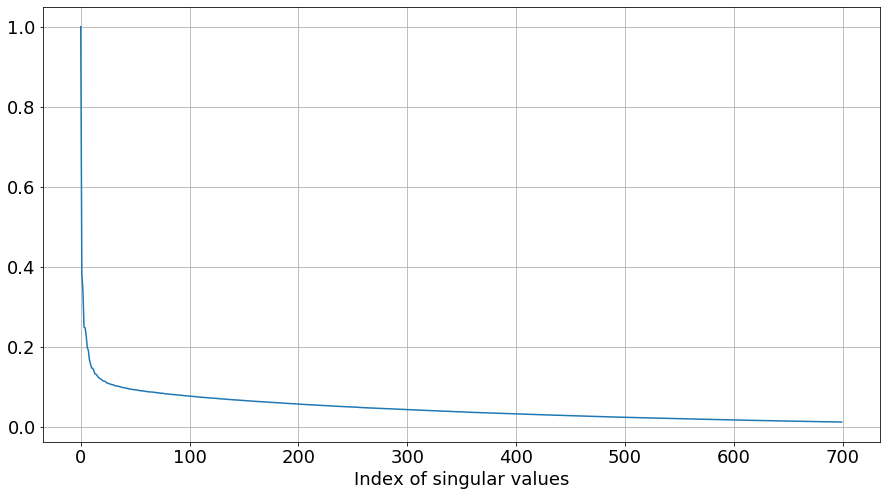

In [69]:
plt.figure(figsize = [15,8])
plt.plot(s[::-1]/s[-1])
plt.xlabel("Index of singular values", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(True)

----

In [73]:
import time
start = time.time()
u, s, vt = svds(base_mat_csr, k = 700)
l = u.dot(np.diag(s).dot(vt))
print(time.time() - start)

2.940762758255005


In [71]:
print('Error for aproximation is: ',round(np.linalg.norm(base_mat - l, 2),3))

Error for aproximation is:  7.115
